# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [3]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [5]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [6]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [7]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
uformerpool = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
_, testImages, _, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
)

[INFO] found 1616 examples in the test set...


In [9]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()

In [10]:
uformerpool = uformerpool.to(DEVICE)
optpool = torch.optim.Adam(uformerpool.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)

In [11]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer.pth')
uformer.load_state_dict(torch.load('../models/uformer_tversky.pth'))
uformerpool.load_state_dict(torch.load('../models/uformerpool_tversky.pth'))

<All keys matched successfully>

In [12]:
def make_prediction(model, image, toCategorical=True):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		if toCategorical:
			predMask = np.argmax(predMask, axis=-1)
			predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [13]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 10:-10,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

In [14]:
uformer_pred = []
uformerpool_pred = []
y_true = []

print('[INFO] Loading test images...')
for testImg in tqdm(testImages):
    uformer_pred.append(make_prediction(uformer, getPredImg(testImg), toCategorical=False))
    uformerpool_pred.append(make_prediction(uformerpool, getPredImg(testImg), toCategorical=False))

print('[INFO] Loading test masks...')
for testMask in tqdm(testMasks):
    testMask = getPredMask(testMask)
    y_true.append(testMask)

uformer_pred = np.array(uformer_pred)
uformerpool_pred = np.array(uformerpool_pred)
y_true = np.array(y_true)

assert uformer_pred.shape == y_true.shape, f"{uformer_pred.shape} != {y_true.shape}"

[INFO] Loading test images...


100%|██████████| 1616/1616 [02:23<00:00, 11.23it/s]


[INFO] Loading test masks...


100%|██████████| 1616/1616 [00:06<00:00, 250.43it/s]


In [15]:
labels_encoding = {
    0: 'BG',
    1: 'Abdominal Wall',
    2: 'Liver',
    3: 'Gastrointestinal Tract',
    4: 'Fat',
    5: 'Grasper',
    6: 'Connective Tissue',
    7: 'Blood',
    8: 'Cystic Duct',
    9: 'L-hook Electrocautery',
    10: 'Gallbladder',
    11: 'Hepatic Vein',
    12: 'Liver Ligament',
}

In [19]:
dice = losses.DiceCoeficient().cuda()
iou = losses.MeanIoUBinary().cuda()

uformer_prediction = torch.Tensor(uformer_pred)
uformerpool_prediction = torch.Tensor(uformerpool_pred)
target = torch.Tensor(y_true)

class_losses = {
    'Uformer Dice Coeficient' : [],
    'Uformer IoU' : [],
    'Uformerpool Dice Coeficient' : [],
    'Uformerpool IoU' : [],
}

for i in range(NUM_CLASSES):
    class_losses['Uformer Dice Coeficient'].append(dice(target[:,:,:,i], uformer_prediction[:,:,:,i]).numpy())
    class_losses['Uformer IoU'].append(iou(target[:,:,:,i], uformer_prediction[:,:,:,i]).numpy())
    class_losses['Uformerpool Dice Coeficient'].append(dice(target[:,:,:,i], uformerpool_prediction[:,:,:,i]).numpy())
    class_losses['Uformerpool IoU'].append(iou(target[:,:,:,i], uformerpool_prediction[:,:,:,i]).numpy())
    
class_losses['Uformer Dice Coeficient'].append(dice(target, uformer_prediction).numpy())
class_losses['Uformer IoU'].append(iou(target, uformer_prediction).numpy())
class_losses['Uformerpool Dice Coeficient'].append(dice(target, uformerpool_prediction).numpy())
class_losses['Uformerpool IoU'].append(iou(target, uformerpool_prediction).numpy())

indexes = list(labels_encoding.values())

indexes.append('Final')

df = pd.DataFrame(class_losses, index=indexes)
df['Uformer Dice Coeficient'] = df['Uformer Dice Coeficient'].map('{:.4f}'.format)
df['Uformer IoU'] = df['Uformer IoU'].map('{:.4f}'.format)
df['Uformerpool Dice Coeficient'] = df['Uformerpool Dice Coeficient'].map('{:.4f}'.format)
df['Uformerpool IoU'] = df['Uformerpool IoU'].map('{:.4f}'.format)

df

,Uformer Dice Coeficient,Uformer IoU,Uformerpool Dice Coeficient,Uformerpool IoU
BG,0.9924,0.9850,0.9934,0.9869
Abdominal Wall,0.9757,0.9526,0.9769,0.9548
Liver,0.9615,0.9258,0.9591,0.9214
Gastrointestinal Tract,0.9123,0.8388,0.9290,0.8675
Fat,0.9577,0.9189,0.9614,0.9257
Grasper,0.8867,0.7965,0.8492,0.7380
Connective Tissue,0.8905,0.8026,0.9156,0.8444
Blood,0.0000,0.0000,0.7497,0.5997
Cystic Duct,0.0000,0.0000,0.0000,0.0000
L-hook Electrocautery,0.9214,0.8543,0.9193,0.8506


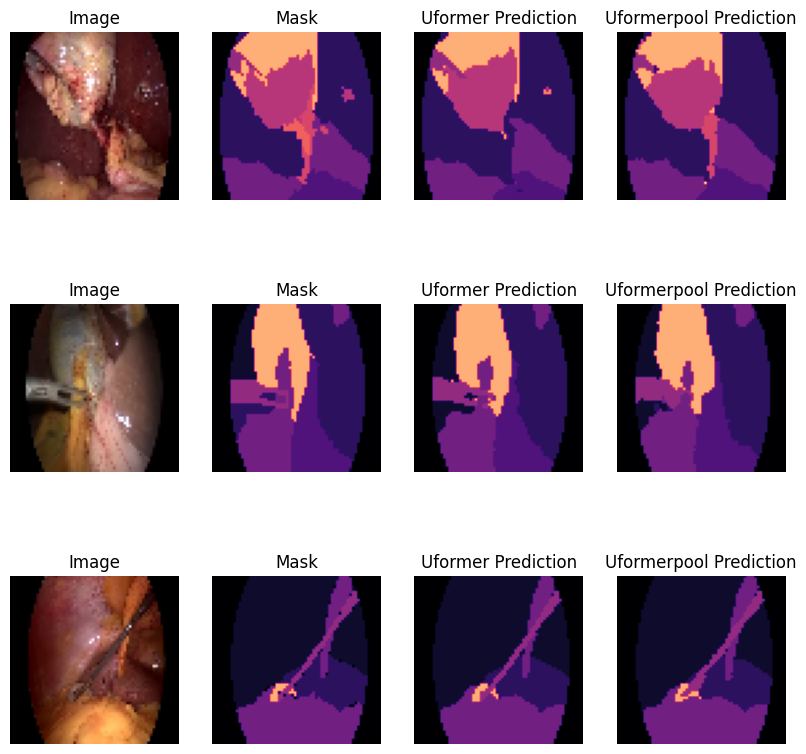

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(3, 4, 1 + 4*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(3, 4, 2 + 4*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(3, 4, 3 + 4*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Uformer Prediction')
    plt.axis("off")

    pred = make_prediction(uformerpool, img)
    plt.subplot(3, 4, 4 + 4*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Uformerpool Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota